## LightGBM

In [1]:
import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

c:\Users\user\miniconda3\envs\ml_yp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

Предобработаем тексты пресс-релизов.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words("russian"))
def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)
tf_idf = vectorizer.fit_transform(X.release)

Подберем параметры с помощью optuna, но смотреть будем только на точность, так как вычисление calc_metrics занимает очень много времени

In [4]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, random_state=42, test_size=0.2)


def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
    }
    model = LGBMClassifier(
        num_leaves=params["num_leaves"],
        n_estimators=params["n_estimators"],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        min_data_in_leaf=params['min_data_in_leaf'],
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        verbosity=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 59. Best value: 0.7: 100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


In [5]:
study.best_params

{'max_depth': 8,
 'num_leaves': 17,
 'min_data_in_leaf': 1,
 'n_estimators': 561,
 'learning_rate': 0.09397049607554396}

              precision    recall  f1-score   support

        -1.0       0.59      0.43      0.50        23
         0.0       0.44      0.57      0.50        28
         1.0       0.59      0.53      0.56        19

    accuracy                           0.51        70
   macro avg       0.54      0.51      0.52        70
weighted avg       0.53      0.51      0.52        70



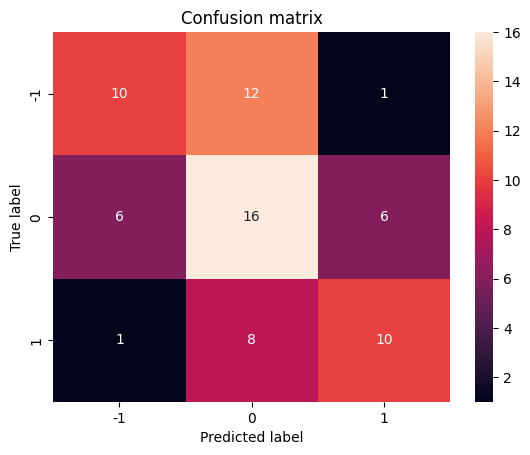

In [6]:
model = LGBMClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    min_data_in_leaf=study.best_params['min_data_in_leaf'],
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    verbosity=-1
    )
metric, model = calc_metrics(
    tf_idf,
    y,
    model,
    name="TF-IDF LigthGBM"
)

In [7]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.742857,0.745614,0.749755,0.743050,0.840990,0.844114
K-neighbors tf_idf pca,0.728571,0.734787,0.727035,0.751111,0.816386,0.821299
K-neighbors word2vec,0.657143,0.637422,0.641441,0.745632,0.787306,0.789760
K-neighbors weighted word2vec,0.657143,0.637422,0.641441,0.745632,0.795419,0.797633
TF-IDF SelectFromModel Random Forest,0.642857,0.642165,0.627874,0.695332,0.798339,0.805117
TF-IDF PCA Random Forest,0.642857,0.640412,0.630462,0.685668,0.818108,0.823213
Word2Vec Random Forest,0.571429,0.571970,0.560586,0.603785,0.730344,0.735650
TF-IDF LigthGBM,0.514286,0.518519,0.510842,0.540305,0.711242,0.719380


Попробуем еще подобрать параметры для неглубоких деревьев, до 5, но увеличив их количество.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, random_state=42, test_size=0.2)


def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
    }
    model = LGBMClassifier(
        num_leaves=params["num_leaves"],
        n_estimators=params["n_estimators"],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        min_data_in_leaf=params['min_data_in_leaf'],
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        verbosity=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 67. Best value: 0.8: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


In [9]:
study.best_params

{'max_depth': 4,
 'num_leaves': 52,
 'min_data_in_leaf': 1,
 'n_estimators': 522,
 'learning_rate': 0.17635998497017952}

              precision    recall  f1-score   support

        -1.0       0.55      0.52      0.53        23
         0.0       0.46      0.61      0.52        28
         1.0       0.55      0.32      0.40        19

    accuracy                           0.50        70
   macro avg       0.52      0.48      0.49        70
weighted avg       0.51      0.50      0.49        70



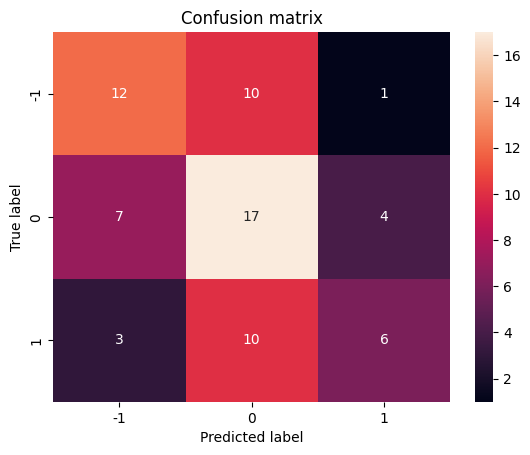

In [10]:
model = LGBMClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    min_data_in_leaf=study.best_params['min_data_in_leaf'],
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    verbosity=-1
    )
metric, model = calc_metrics(
    tf_idf,
    y,
    model,
    name="TF-IDF LigthGBM"
)

In [12]:
metric

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF LigthGBM,0.5,0.48547,0.481557,0.51679,0.712886,0.71908


В итоге, попробовав три разных бустинга (XGboost, CatBoost, LightGBM), не удалось приблизится к лучшей линейной модели.

In [17]:
metrics.to_csv('metrics.csv')